<a href="https://colab.research.google.com/github/MykhailoNagin/SEB/blob/main/SEB_Mykhailo_Naginailov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn
import sklearn.model_selection
import pylab as pl
import seaborn as sns
import collections
import warnings

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay, classification_report, make_scorer, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from google.colab import drive

import warnings
warnings.filterwarnings('ignore')


from sklearn.linear_model import LogisticRegression
import os

In [194]:
# Importing data

# Check if we are in Colab to determine the path
try:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = '/content/drive/MyDrive/SEB/'
except ImportError:
    base_path = './'

par_model_df = pd.read_csv(os.path.join(base_path, 'par_model.csv'))
dat_scoring_df = pd.read_csv(os.path.join(base_path, 'dat_scoring.csv'))
dat_obligor_df = pd.read_csv(os.path.join(base_path, 'dat_obligor.csv'))
par_pools_df = pd.read_csv(os.path.join(base_path, 'par_pools.csv'))
dat_arrangement_df = pd.read_csv(os.path.join(base_path, 'dat_arrangement.csv'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [195]:
# Merging dat_scoring_df and dat_obligor_df on 'IP_ID' and 'YEAR'
merged_scoring_obligor_df = pd.merge(dat_scoring_df, dat_obligor_df, on=['IP_ID', 'YEAR'], how='inner')

# Merging the previously created merged_scoring_obligor_df with dat_arrangement_df on 'YEAR' and 'AR_ID'
final_merged_df = pd.merge(merged_scoring_obligor_df, dat_arrangement_df, on=['YEAR', 'AR_ID'], how='inner')


# Displaying the first 5 rows of the final merged DataFrame
print(f"Initial Row Count: {len(final_merged_df)}")
print("Final Merged DataFrame head:")
display(final_merged_df.head())
# A Contract 'AR_ID' is unique per Year 'YEAR'
pk_cols = ['YEAR', 'AR_ID']

# Finding rows that share the same 'Year' and 'AR_ID
dupes = final_merged_df[final_merged_df.duplicated(subset=pk_cols, keep=False)].sort_values(by=pk_cols)

if len(dupes) > 0:
    print(f"\nFound {len(dupes)} duplicate rows.")

    # Checking if the duplicates are EXACT copies of each other
    perfect_copies = final_merged_df.duplicated(keep=False) # Checks ALL columns
    # Checking for "Evil Twins" (Same ID, Different Data)
    evil_twins = final_merged_df[final_merged_df.duplicated(subset=pk_cols, keep=False) & ~perfect_copies]

    if len(evil_twins) > 0:
        print(f"\n Critical warning: found {len(evil_twins)} 'CONFLICTING' duplicates!")
        print("Displaying conflicts:")
        display(evil_twins.head(20))
        # Explroing what do they look like
    else:
        print("\n All duplicates are PERFECT CLONES.")
        print("It is safe to delete them.")

else:
    print("No duplicates found. The merge was clean.")


# Because most of them following the logic: first duplicate of the pair contains values in columns where the second doesn't
# I decided to delete just first. But usuualy in credit risk we care about 'bigger' numbers - to avoid bigger potential risks
initial_count = len(final_merged_df)
final_merged_df = final_merged_df.drop_duplicates(subset=pk_cols, keep='first')
final_count = len(final_merged_df)

print("\n" + "="*30)
print(f"Cleanup Complete:")
print(f"Rows Deleted: {initial_count - final_count}")
print(f"Final Dataset Size: {final_count}")

Initial Row Count: 32224
Final Merged DataFrame head:


,YEAR,IP_ID,AR_ID,PD,PD_POOL,DFLT_FLAG,AGE,EDUCATION,DEBT_RATIO,DPD,M_LAST_DPD
0,2022,CFG053,2795120,0.9925,5.0000,1,70.0000,2.0000,1.0000,1.0000,6.0000
1,2022,NNA451,10210477,0.0000,1.0000,0,72.0000,2.0000,0.8048,NaN,NaN
2,2022,VLZ931,24787848,0.0000,1.0000,0,44.0000,2.0000,0.1365,NaN,NaN
3,2022,VVF064,35869938,0.0000,1.0000,0,63.0000,1.0000,0.5224,NaN,NaN
4,2022,DXH176,71765042,0.0000,1.0000,0,20.0000,1.0000,0.2958,NaN,NaN



Found 2773 duplicate rows.

 Critical warning: found 1204 'CONFLICTING' duplicates!
Displaying conflicts:


,YEAR,IP_ID,AR_ID,PD,PD_POOL,DFLT_FLAG,AGE,EDUCATION,DEBT_RATIO,DPD,M_LAST_DPD
14,2022,CGC248,28580548,0.0000,1.0000,0,48.0000,1.0000,0.1910,NaN,NaN
15,2022,CGC248,28580548,0.0000,1.0000,0,48.0000,1.0000,NaN,NaN,NaN
49,2022,ZFG062,26749062,0.0000,1.0000,0,42.0000,1.0000,0.1794,NaN,NaN
50,2022,ZFG062,26749062,0.0000,1.0000,0,42.0000,1.0000,NaN,NaN,NaN
63,2022,NXT275,50254034,0.0000,1.0000,0,37.0000,2.0000,0.5586,NaN,NaN
64,2022,NXT275,50254034,0.0000,1.0000,0,37.0000,2.0000,NaN,NaN,NaN
77,2022,LCL666,26962273,0.0000,1.0000,0,36.0000,2.0000,0.8081,NaN,NaN
78,2022,LCL666,26962273,0.0000,1.0000,0,36.0000,2.0000,NaN,NaN,NaN
155,2022,OBR471,79359896,0.0000,1.0000,0,32.0000,1.0000,0.8011,NaN,NaN
156,2022,OBR471,79359896,0.0000,1.0000,0,32.0000,1.0000,NaN,NaN,NaN



Cleanup Complete:
Rows Deleted: 1396
Final Dataset Size: 30828


In [196]:
# Check for the data types of entries
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30828 entries, 0 to 32222
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   YEAR        30828 non-null  int64  
 1   IP_ID       30828 non-null  object 
 2   AR_ID       30828 non-null  int64  
 3   PD          30828 non-null  float64
 4   PD_POOL     30828 non-null  float64
 5   DFLT_FLAG   30828 non-null  int64  
 6   AGE         30183 non-null  float64
 7   EDUCATION   30048 non-null  float64
 8   DEBT_RATIO  30410 non-null  float64
 9   DPD         3984 non-null   float64
 10  M_LAST_DPD  3984 non-null   float64
dtypes: float64(7), int64(3), object(1)
memory usage: 2.8+ MB


In [197]:
# Check for the descriptive statistics
print(final_merged_df.describe())

            YEAR         AR_ID         PD    PD_POOL  DFLT_FLAG        AGE  \
count 30828.0000    30828.0000 30828.0000 30828.0000 30828.0000 30183.0000   
mean   2023.0018 50216407.4031     0.1453     2.2965     0.2005    51.4079   
std       0.8172 28719030.5119     0.3419     1.5061     0.4004    14.9040   
min    2022.0000     4603.0000     0.0000     1.0000     0.0000    18.0000   
25%    2022.0000 25484013.0000     0.0000     1.0000     0.0000    40.0000   
50%    2023.0000 50496703.0000     0.0009     2.0000     0.0000    52.0000   
75%    2024.0000 74703697.0000     0.0083     3.0000     0.0000    64.0000   
max    2024.0000 99988783.0000     1.0000     5.0000     1.0000    77.0000   

       EDUCATION  DEBT_RATIO       DPD  M_LAST_DPD  
count 30048.0000  30410.0000 3984.0000   3984.0000  
mean      2.2014      0.3662   32.9716      5.3828  
std       0.8692      0.3227   89.6290      3.5016  
min       1.0000      0.0000    1.0000      0.0000  
25%       1.0000      0.0932    

In [198]:
# Check for missing values before plotting
print(final_merged_df.isnull().sum())

YEAR              0
IP_ID             0
AR_ID             0
PD                0
PD_POOL           0
DFLT_FLAG         0
AGE             645
EDUCATION       780
DEBT_RATIO      418
DPD           26844
M_LAST_DPD    26844
dtype: int64


In [199]:
# Making sure in consistency of our data
# Checking whether the logic of the data is violated
# Rule: If DPD is 0, Default Flag should be 0.
ghost_defaults = final_merged_df[
    (final_merged_df['DPD'] == 0) &
    (final_merged_df['DFLT_FLAG'] == 1)
]
if len(ghost_defaults) > 0:
    print(f"    Found {len(ghost_defaults)} 'Ghost Defaults'.")
    print(f"      (Rows with 0 DPD but Default=1). This contradicts the delinquency logic.")
else:
    print("  Internal Logic is clean (No DPD=0 Defaults found).")

  Internal Logic is clean (No DPD=0 Defaults found).


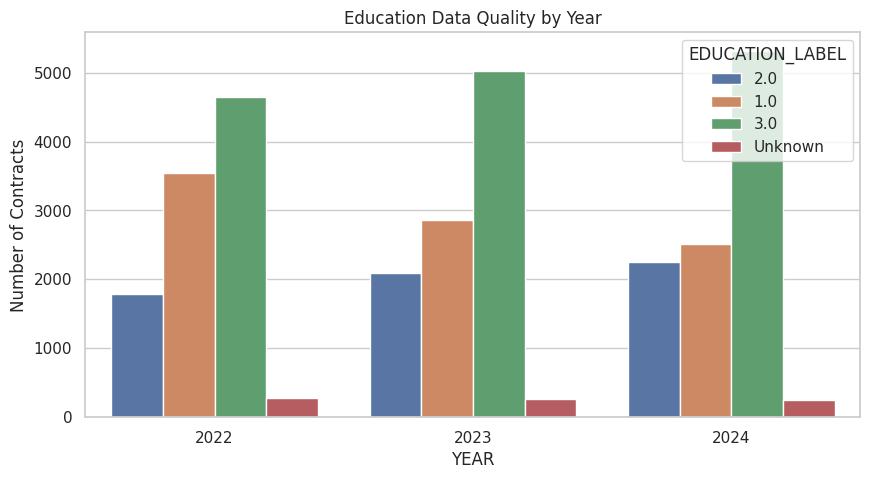

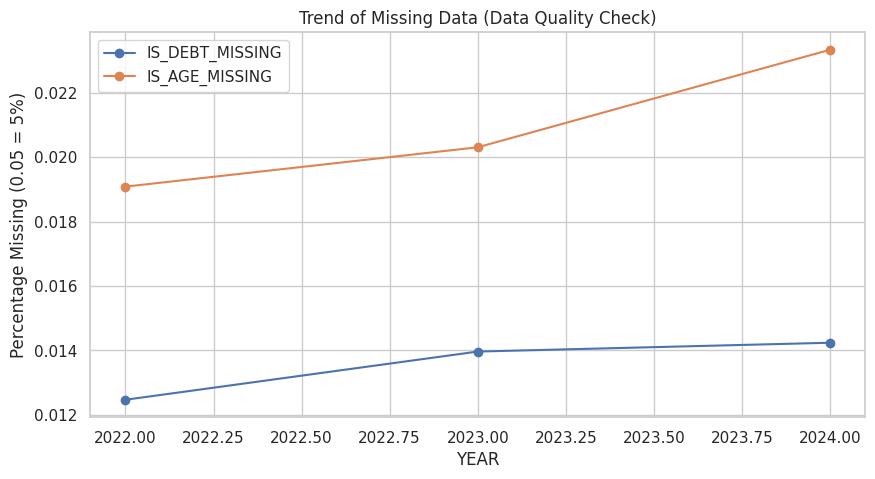

In [200]:
# Creating a copy for visualization
viz_df = final_merged_df.copy()

# 1. Categorical: Label the Unknowns explicitly
viz_df['EDUCATION_LABEL'] = viz_df['EDUCATION'].fillna('Unknown')

# 2. Numerical: Creating a flag to track "Missingness"
viz_df['IS_DEBT_MISSING'] = viz_df['DEBT_RATIO'].isna()
viz_df['IS_AGE_MISSING']  = viz_df['AGE'].isna()


plt.figure(figsize=(10, 5))
# This graph will show "Unknown" as the missing values bar
sns.countplot(data=viz_df, x='YEAR', hue='EDUCATION_LABEL')
plt.title("Education Data Quality by Year")
plt.ylabel("Number of Contracts")
plt.show()

# Calculating the % of missing data per year
missing_trend = viz_df.groupby('YEAR')[['IS_DEBT_MISSING', 'IS_AGE_MISSING']].mean()

# Plotting
missing_trend.plot(kind='line', marker='o', figsize=(10, 5))
plt.title("Trend of Missing Data (Data Quality Check)")
plt.ylabel("Percentage Missing (0.05 = 5%)")
plt.grid(True)
plt.show()

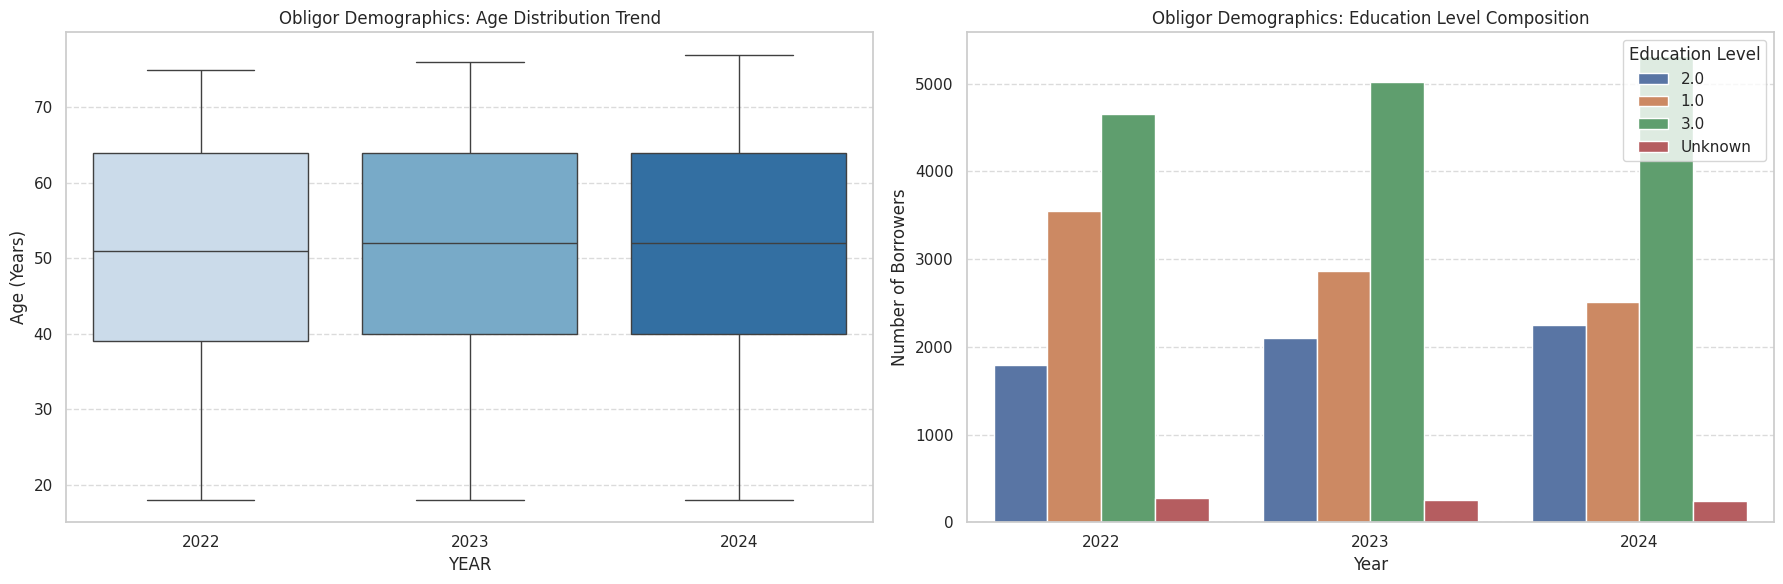

In [201]:
# Prepare the plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1st Chart
# Age
sns.boxplot(data=viz_df, x='YEAR', y='AGE', ax=axes[0], palette="Blues")
axes[0].set_title('Obligor Demographics: Age Distribution Trend')
axes[0].set_ylabel('Age (Years)')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 2nd Chart
# Education
sns.countplot(data=viz_df, x='YEAR', hue='EDUCATION_LABEL', ax=axes[1], palette="deep")
axes[1].set_title('Obligor Demographics: Education Level Composition')
axes[1].set_ylabel('Number of Borrowers')
axes[1].set_xlabel('Year')
axes[1].legend(title='Education Level')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Final layout
plt.tight_layout()
plt.show()

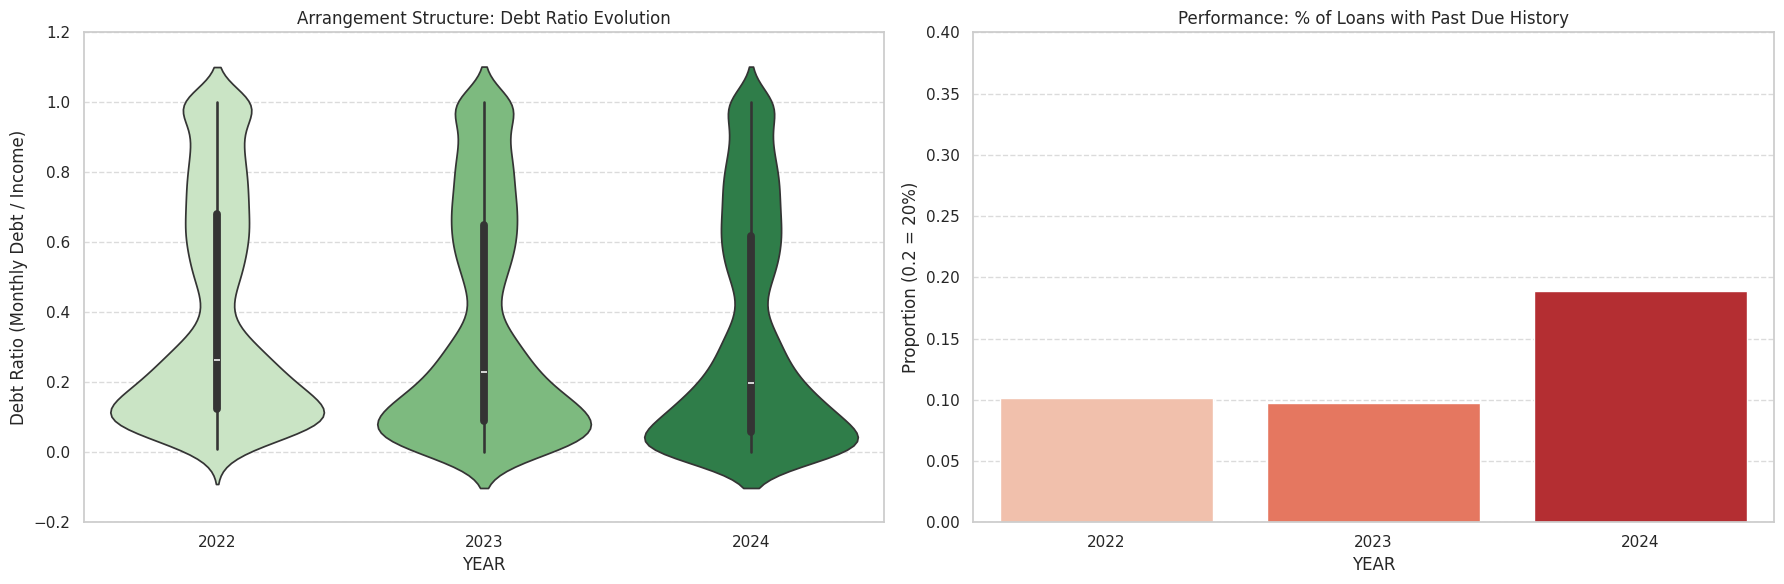

In [202]:
# Preparing the data
# Creating new column
final_merged_df['HAS_PAST_DUE'] = final_merged_df['DPD'] > 0

# Preparing the space for a plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1st Chart
# Violin for the debt ratio
sns.violinplot(data=final_merged_df, x='YEAR', y='DEBT_RATIO', ax=axes[0], palette="Greens")
axes[0].set_title('Arrangement Structure: Debt Ratio Evolution')
axes[0].set_ylabel('Debt Ratio (Monthly Debt / Income)')
axes[0].set_ylim(-0.2, 1.2)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 2nd Chart
# Bar plot for % of loans that have EVER been late
sns.barplot(data=final_merged_df, x='YEAR', y='HAS_PAST_DUE', ax=axes[1], errorbar=None, palette="Reds")
axes[1].set_title('Performance: % of Loans with Past Due History')
axes[1].set_ylabel('Proportion (0.2 = 20%)')
axes[1].set_ylim(0, 0.4)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Layout
plt.tight_layout()
plt.show()

Combining this with your "Education" chart, the story is undeniable: The bank is closing up shop. They are collecting money from old loans (the bottom bulge) but they are refusing to issue new loans (the shrinking top bulge) except to a tiny group of highly educated people.

In banking, this is called a "Run-Off Portfolio." It usually happens when a bank is about to be sold or is terrified of a coming recession. They stop "feeding the beast" and just harvest the cash.

--- ANALYZING FEATURE: M_LAST_DPD (By Year) ---
         count   mean    std    min    25%    50%    75%     max
YEAR                                                            
2022 1041.0000 6.9472 2.5914 0.0000 5.0000 7.0000 9.0000 19.0000
2023  997.0000 3.5577 3.8305 0.0000 0.0000 3.0000 7.0000 15.0000
2024 1946.0000 5.4810 3.3131 1.0000 2.0000 6.0000 8.0000 15.0000


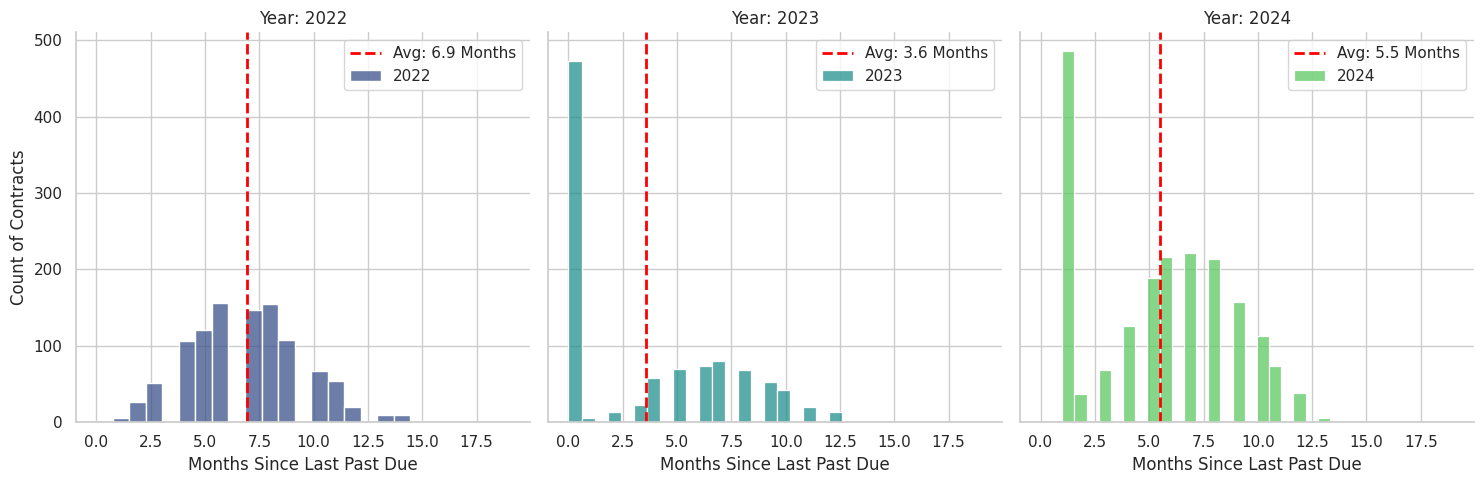

In [203]:
# Ensure we use the clean dataset
df = final_merged_df.copy()

target_col = 'M_LAST_DPD'
print(f"--- ANALYZING FEATURE: {target_col} (By Year) ---")

# 1st Calculating Statistics
# I need the average to see if it's dropping
stats = df.groupby('YEAR')[target_col].describe()
print(stats)

# 2nd Visualizing
g = sns.FacetGrid(df, col="YEAR", height=5, aspect=1, sharey=True, hue="YEAR", palette="viridis")
g.map(sns.histplot, target_col, bins=25, kde=False)
g.set_axis_labels("Months Since Last Past Due", "Count of Contracts")
g.set_titles("Year: {col_name}")

# Adding Mean Lines (vertical line)
for ax, year in zip(g.axes.flatten(), sorted(df['YEAR'].unique())):
    mean_val = df[df['YEAR'] == year][target_col].mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Avg: {mean_val:.1f} Months')
    ax.legend()

plt.tight_layout()
plt.show()

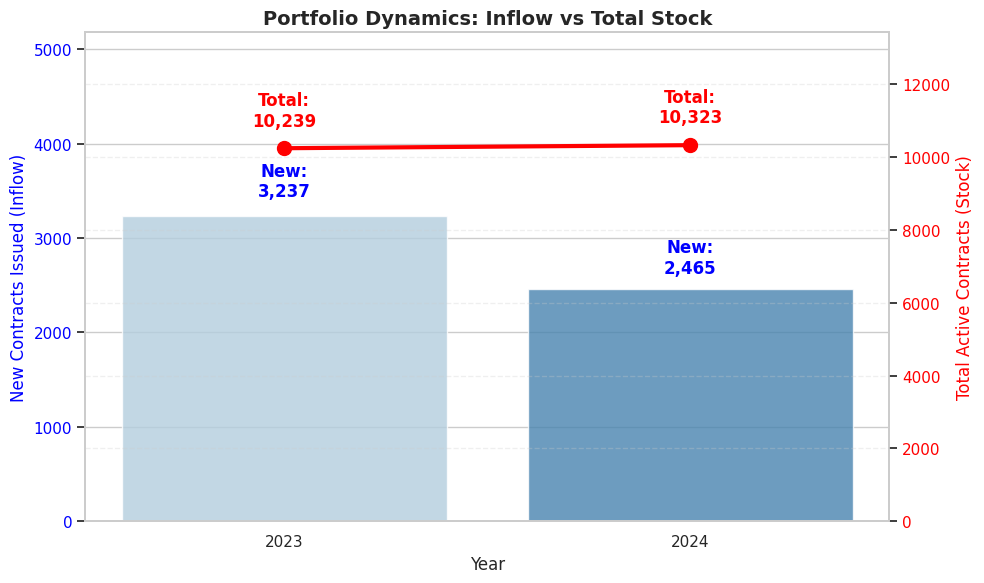

In [204]:
# Loading data
df = final_merged_df.copy()


# 1st Calculation
# New Contracts (Inflow) means - Correct
first_appearance = df.groupby('AR_ID')['YEAR'].min().reset_index()
first_appearance.columns = ['AR_ID', 'START_YEAR']
# I only look at 2023/2024 because it\s not given if 2022 contracts started then or before
new_counts = first_appearance[first_appearance['START_YEAR'].isin([2023, 2024])]['START_YEAR'].value_counts().sort_index()

# 2nd Total Active Contracts
total_active = df[df['YEAR'].isin([2023, 2024])].groupby('YEAR')['AR_ID'].nunique().sort_index()

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting bards
sns.barplot(x=new_counts.index, y=new_counts.values, ax=ax1, palette="Blues", alpha=0.8)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('New Contracts Issued (Inflow)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, max(new_counts.values) * 1.6)

# Labelling
for i, v in enumerate(new_counts.values):
    ax1.text(i, v + (v*0.05), f"New:\n{v:,}", ha='center', va='bottom', color='blue', fontweight='bold')

# Adding the red line
ax2 = ax1.twinx()
ax2.plot(ax1.get_xticks(), total_active.values, color='red', marker='o', linewidth=3, markersize=10)
ax2.set_ylabel('Total Active Contracts (Stock)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(total_active.values) * 1.3)

# Labelling the line
for i, v in enumerate(total_active.values):
    ax2.text(i, v + (v*0.05), f"Total:\n{v:,}", ha='center', va='bottom', color='red', fontweight='bold')

# Layout
plt.title('Portfolio Dynamics: Inflow vs Total Stock', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

--- Portfolio Stability ---
   Year  Total Contracts
0  2022            10266
1  2023            10239
2  2024            10323
----------------------------------


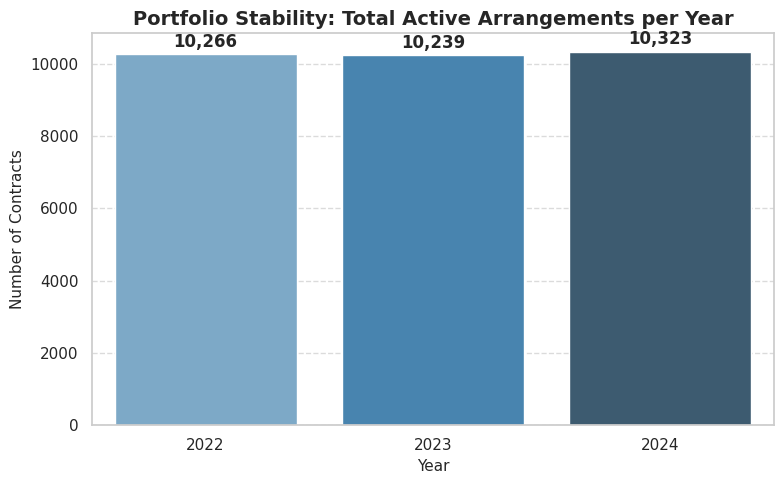

In [205]:
# Loading the data
df = final_merged_df.copy()

# Setting the style
sns.set_theme(style="whitegrid")

# Calculation
# Counting unique Arrangements (AR_ID) per Year to get total contracts
yearly_vol = df.groupby('YEAR')['AR_ID'].nunique().reset_index()
yearly_vol.columns = ['Year', 'Total Contracts']

# Printing
print("--- Portfolio Stability ---")
print(yearly_vol)
print("----------------------------------")

# Plotting
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=yearly_vol, x='Year', y='Total Contracts', palette='Blues_d')

# Adding titles
plt.title('Portfolio Stability: Total Active Arrangements per Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Contracts', fontsize=11)
plt.xlabel('Year', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding values next to bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontweight='bold')

plt.tight_layout()
plt.show()

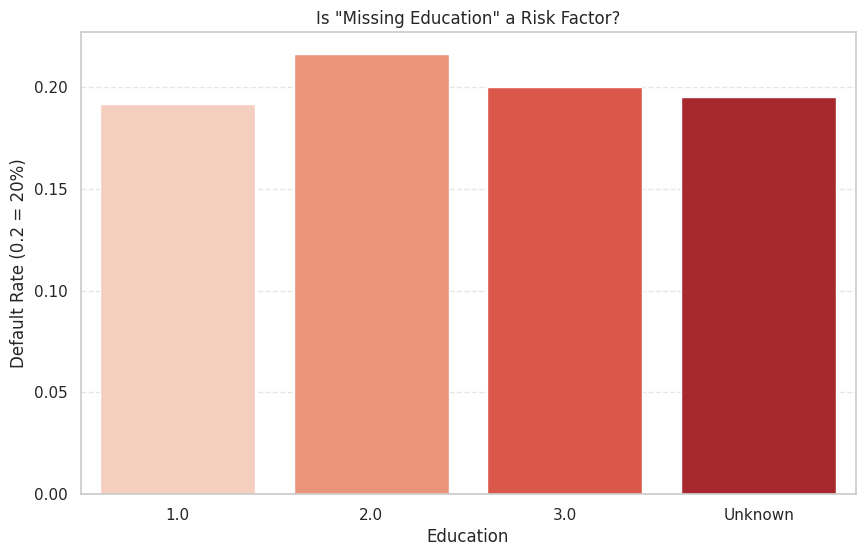

In [206]:
# Checking behaviour of missing values for education
education_risk = viz_df.groupby('EDUCATION_LABEL')['DFLT_FLAG'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=education_risk, x='EDUCATION_LABEL', y='DFLT_FLAG', palette="Reds")

plt.title('Is "Missing Education" a Risk Factor?')
plt.ylabel('Default Rate (0.2 = 20%)')
plt.xlabel('Education')
plt.grid(axis='y', linestyle='--', alpha=0.5)


Default Rates by Age Group:
              AGE_GROUP  DFLT_FLAG
0              1. Young     0.1854
1          2. Mid-Young     0.1980
2            3. Mid-Old     0.2004
3                4. Old     0.2183
4  5. Missing / Unknown     0.2186


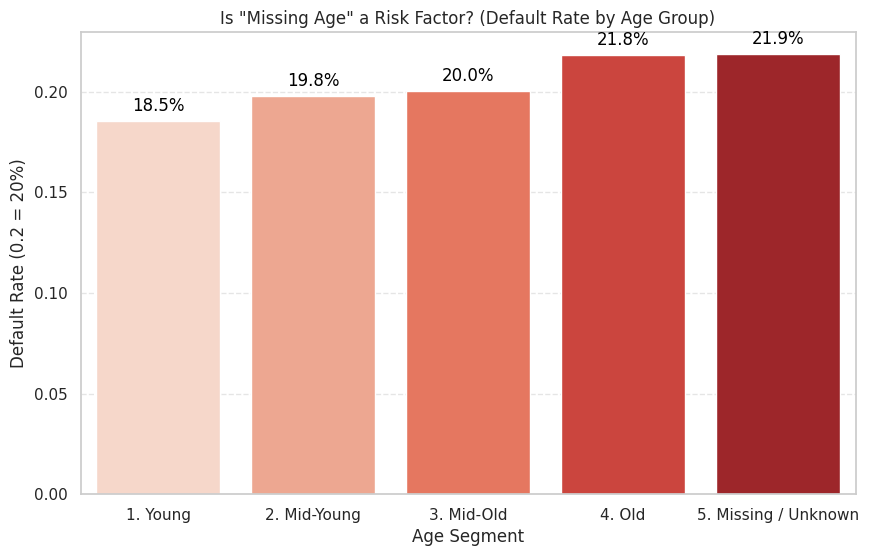

In [207]:
# Loading data
viz_df = final_merged_df.copy()

# Creating 4 Age Groups
viz_df['AGE_GROUP'] = pd.qcut(viz_df['AGE'], q=4, labels=['1. Young', '2. Mid-Young', '3. Mid-Old', '4. Old'])
viz_df['AGE_GROUP'] = viz_df['AGE_GROUP'].astype(str)
# Labelling missing values
viz_df.loc[viz_df['AGE'].isna(), 'AGE_GROUP'] = '5. Missing / Unknown'

# Calculating the risk
age_risk = viz_df.groupby('AGE_GROUP')['DFLT_FLAG'].mean().reset_index()

# Printing
print("Default Rates by Age Group:")
print(age_risk)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=age_risk, x='AGE_GROUP', y='DFLT_FLAG', palette="Reds")

plt.title('Is "Missing Age" a Risk Factor? (Default Rate by Age Group)')
plt.ylabel('Default Rate (0.2 = 20%)')
plt.xlabel('Age Segment')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding labels
for index, row in age_risk.iterrows():
    plt.text(index, row.DFLT_FLAG + 0.005, f"{row.DFLT_FLAG:.1%}", color='black', ha="center")

plt.show()

Default Rates by Debt Load:
             DEBT_GROUP  DFLT_FLAG
0           1. Low Debt     0.2258
1        2. Medium Debt     0.1838
2          3. High Debt     0.1936
3     4. Very High Debt     0.1982
4  5. Missing / Unknown     0.2081


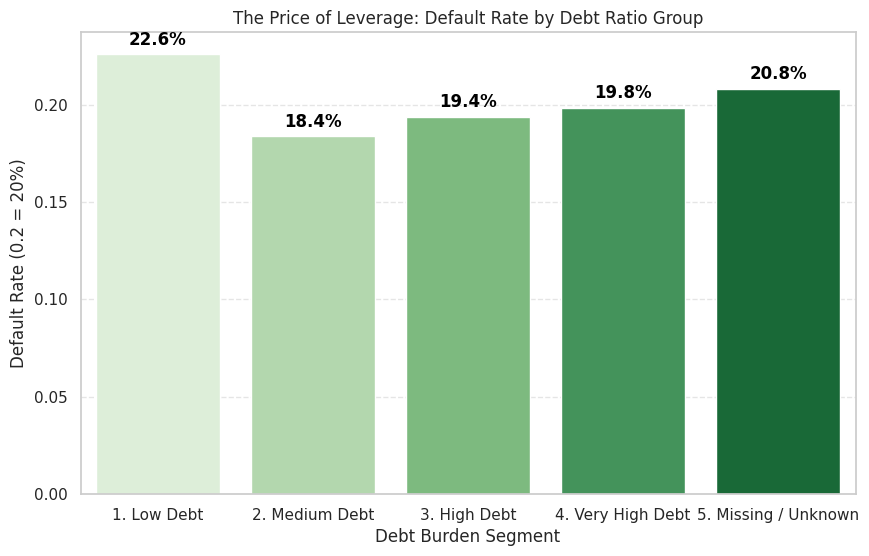

In [208]:
# Loading data

viz_df = final_merged_df.copy()

# Creating 4 Debt Groups
# duplicates='drop' handling cases where many people have exactly 0 debt
viz_df['DEBT_GROUP'] = pd.qcut(viz_df['DEBT_RATIO'], q=4, labels=['1. Low Debt', '2. Medium Debt', '3. High Debt', '4. Very High Debt'], duplicates='drop')
viz_df['DEBT_GROUP'] = viz_df['DEBT_GROUP'].astype(str)

# Labelling missing values
viz_df.loc[viz_df['DEBT_RATIO'].isna(), 'DEBT_GROUP'] = '5. Missing / Unknown'

# Calculating the risk
debt_risk = viz_df.groupby('DEBT_GROUP')['DFLT_FLAG'].mean().reset_index()

# Printing
print("Default Rates by Debt Load:")
print(debt_risk)

# Visualising
plt.figure(figsize=(10, 6))
sns.barplot(data=debt_risk, x='DEBT_GROUP', y='DFLT_FLAG', palette="Greens")

plt.title('The Price of Leverage: Default Rate by Debt Ratio Group')
plt.ylabel('Default Rate (0.2 = 20%)')
plt.xlabel('Debt Burden Segment')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding labels
for index, row in debt_risk.iterrows():
    plt.text(index, row.DFLT_FLAG + 0.005, f"{row.DFLT_FLAG:.1%}", color='black', ha="center", fontweight='bold')

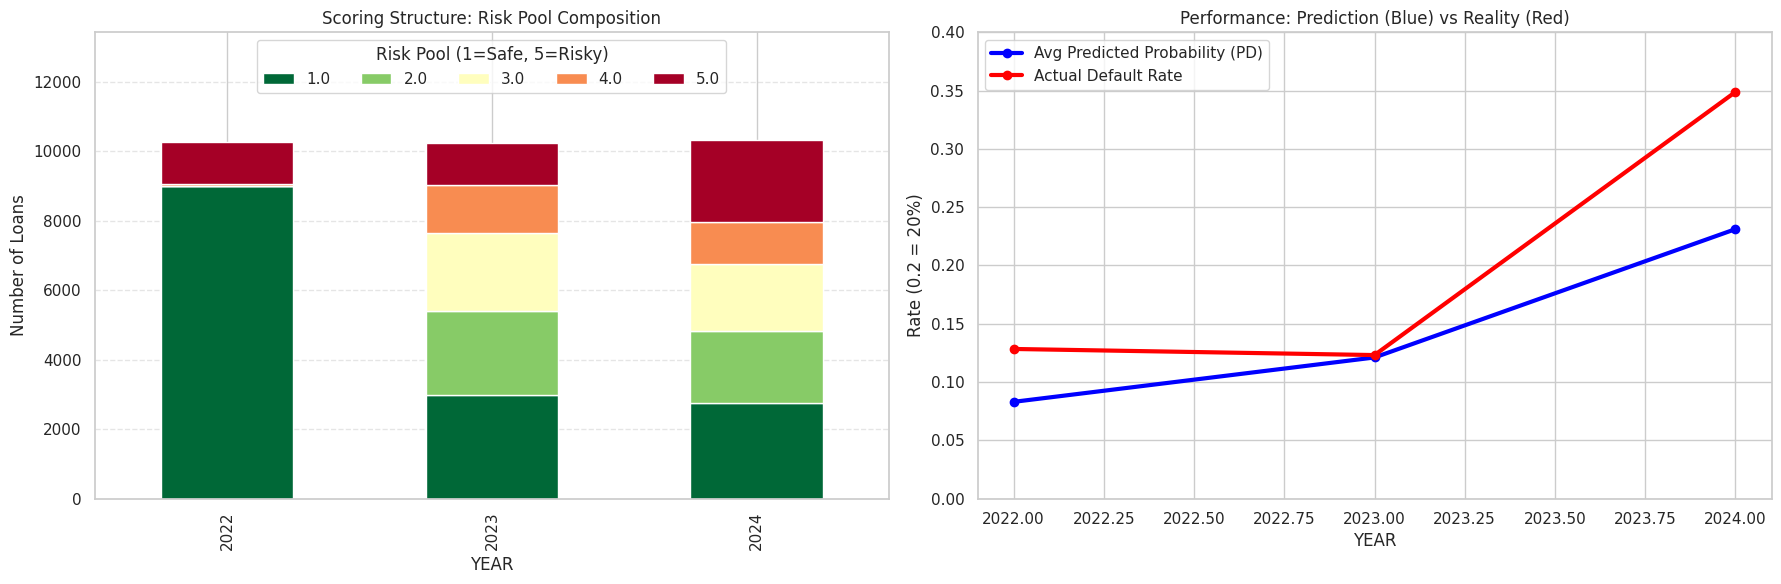

In [209]:
# Preparing the place
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1st Chart
# Risk Composition
risk_pool_data = pd.crosstab(final_merged_df['YEAR'], final_merged_df['PD_POOL'])

risk_pool_data.plot(
    kind='bar',
    stacked=True,
    ax=axes[0],
    colormap='RdYlGn_r'
)

# Adjusting the plot
max_height = risk_pool_data.sum(axis=1).max()
axes[0].set_ylim(0, max_height * 1.3)

axes[0].set_title('Scoring Structure: Risk Pool Composition')
axes[0].set_ylabel('Number of Loans')

axes[0].legend(title='Risk Pool (1=Safe, 5=Risky)', loc='upper center', ncol=5)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# 2nd Chart
# Prediction Vs Reality for the risk
pd_trend = final_merged_df.groupby('YEAR')[['PD', 'DFLT_FLAG']].mean()
pd_trend.plot(
    kind='line',
    marker='o',
    ax=axes[1],
    color=['blue', 'red'],
    linewidth=3
)
axes[1].set_title('Performance: Prediction (Blue) vs Reality (Red)')
axes[1].set_ylabel('Rate (0.2 = 20%)')
axes[1].set_ylim(0, 0.4)
axes[1].legend(['Avg Predicted Probability (PD)', 'Actual Default Rate'], loc='upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [210]:
# Checking the 2022 year for the pool composition
checking_pools = final_merged_df.groupby(['YEAR', 'PD_POOL']).count()
display(checking_pools)

IP_ID  AR_ID    PD  DFLT_FLAG   AGE  EDUCATION  DEBT_RATIO  \
YEAR PD_POOL                                                               
2022 1.0000    8986   8986  8986       8986  8816       8744        8873   
     2.0000       6      6     6          6     6          6           6   
     3.0000       6      6     6          6     6          6           6   
     4.0000      53     53    53         53    52         53          53   
     5.0000    1215   1215  1215       1215  1190       1180        1200   
2023 1.0000    2969   2969  2969       2969  2969       2969        2960   
     2.0000    2442   2442  2442       2442  2360       2376        2396   
     3.0000    2228   2228  2228       2228  2198       2108        2199   
     4.0000    1375   1375  1375       1375  1315       1340        1334   
     5.0000    1225   1225  1225       1225  1189       1187        1207   
2024 1.0000    2742   2742  2742       2742  2742       2742        2731   
     2.0000    2084   2084  2084       2084  1997       2032        2045   
     3.0000    1937   1937  1937       1937  1900       1824        1916   
     4.0000    1188   1188  1188       1188  1126       1160        1157   
     5.0000    2372   2372  2372       2372  2317       2321        2327   

               DPD  M_LAST_DPD  HAS_PAST_DUE  
YEAR PD_POOL                                  
2022 1.0000      3           3          8986  
     2.0000      6           6             6  
     3.0000      6           6             6  
     4.0000     44          44            53  
     5.0000    982         982          1215  
2023 1.0000      0           0          2969  
     2.0000      0           0          2442  
     3.0000      0           0          2228  
     4.0000      0           0          1375  
     5.0000    997         997          1225  
2024 1.0000      0           0          2742  
     2.0000      0           0          2084  
     3.0000      0           0          1937  
     4.0000      0           0          1188  
     5.0000   1946        1946          2372

  Year_Transition  Total_Defaults  Survived_Defaults  Retention_Rate
0    2022 -> 2023            1318                882          0.6692
1    2023 -> 2024            1261                847          0.6717


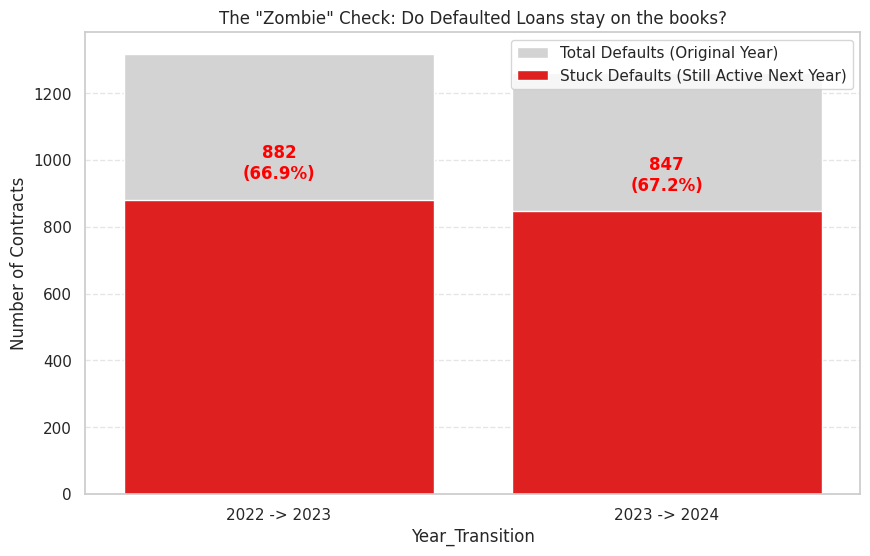

In [211]:

# Defining logic/function
def track_default_survival(df):
    results = []
    years = sorted(df['YEAR'].unique())

    # Can only check the "survival" for the next year
    # Check 2022 -> 2023 and 2023 -> 2024
    for i in range(len(years) - 1):
        current_year = years[i]
        next_year = years[i+1]

        # 1. Finding all Defaulted Contract IDs in the current year
        defaulters_current = set(df[(df['YEAR'] == current_year) & (df['DFLT_FLAG'] == 1)]['AR_ID'])
        total_defaults = len(defaulters_current)

        if total_defaults == 0:
            continue

        # 2. Checking how many of these IDs exist in the Next Year
        next_year_ids = set(df[df['YEAR'] == next_year]['AR_ID'])

        # Intersection: The Defaults that stayed
        surviving_defaults = defaulters_current.intersection(next_year_ids)
        survived_count = len(surviving_defaults)

        results.append({
            'Year_Transition': f"{current_year} -> {next_year}",
            'Total_Defaults': total_defaults,
            'Survived_Defaults': survived_count,
            'Retention_Rate': survived_count / total_defaults
        })

    return pd.DataFrame(results)

# 2nd Checking our dataframe
survival_df = track_default_survival(final_merged_df)
print(survival_df)

# Visualising
plt.figure(figsize=(10, 6))

sns.barplot(data=survival_df, x='Year_Transition', y='Total_Defaults', color='lightgrey', label='Total Defaults (Original Year)')
sns.barplot(data=survival_df, x='Year_Transition', y='Survived_Defaults', color='red', label='Stuck Defaults (Still Active Next Year)')

plt.title('The "Zombie" Check: Do Defaulted Loans stay on the books?')
plt.ylabel('Number of Contracts')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding labels
for i, row in survival_df.iterrows():
  # Labelling "survivors" with red
    plt.text(i, row.Survived_Defaults + 50, f"{int(row.Survived_Defaults)}\n({row.Retention_Rate:.1%})",
             ha='center', va='bottom', color='red', fontweight='bold')

plt.show()

In [212]:
# Measuring the predictions
# Checking the Prediction Vs Reality
calibration_check = final_merged_df.groupby('YEAR').apply(
    lambda x: pd.Series({
        'Avg_Predicted_PD (Blue Line)': x['PD'].mean(),
        'Actual_Default_Rate (Red Line)': x['DFLT_FLAG'].mean(),
        'Prediction_Error': x['PD'].mean() - x['DFLT_FLAG'].mean(),
        'EO_Ratio (Target = 1.0)': x['PD'].mean() / x['DFLT_FLAG'].mean()
    })
).reset_index()

print("--- 1. Calibration Accuracy ---")
print(calibration_check)

# Checking if the Risk Tiers actually worked.
tier_validation = final_merged_df.groupby(['YEAR', 'PD_POOL'])['DFLT_FLAG'].mean().unstack()

print("\n--- 2. Risk Tier Logic Check ---")
print("Do the values increase from Left (Pool 1) to Right (Pool 5)?")
print(tier_validation)

# Calculating Area under the Curve (AUC)
# Auc 'random guessing' (0.5)
# Auc 'perfect' (1.0)

print("\nActually asnwers Question 4 part (B) as well RISK DIFFERENTIATION (AUC Scores):")
for year in sorted(df['YEAR'].unique()):
    yearly_data = df[df['YEAR'] == year]
    # We need both 0s and 1s to calc AUC
    if len(yearly_data['DFLT_FLAG'].unique()) > 1:
        auc = roc_auc_score(yearly_data['DFLT_FLAG'], yearly_data['PD'])
        gini = (auc * 2) - 1
        print(f"   - {year}: AUC = {auc:.4f} (Gini = {gini:.4f})")
    else:
        print(f"   - {year}: Cannot calculate AUC (Only one class present)")

--- 1. Calibration Accuracy (Right Graph Analysis) ---
   YEAR  Avg_Predicted_PD (Blue Line)  Actual_Default_Rate (Red Line)  \
0  2022                        0.0830                          0.1284   
1  2023                        0.1211                          0.1232   
2  2024                        0.2312                          0.3488   

   Prediction_Error  EO_Ratio (Target = 1.0)  
0           -0.0454                   0.6466  
1           -0.0021                   0.9832  
2           -0.1177                   0.6626  

--- 2. Risk Tier Logic Check (Left Graph Analysis) ---
Do the values increase from Left (Pool 1) to Right (Pool 5)?
PD_POOL  1.0000  2.0000  3.0000  4.0000  5.0000
YEAR                                           
2022     0.0051  0.5000  1.0000  0.9623  0.9975
2023     0.0027  0.0041  0.0081  0.0196  0.9780
2024     0.1543  0.1569  0.1507  0.1692  0.9941

Actually asnwers Question 4 part (B) as well RISK DIFFERENTIATION (AUC Scores):
   - 2022: AUC = 0.9899 (G

In [213]:
# Loading Data
regression_df = final_merged_df.copy()
# Renaming columns
regression_df = regression_df.rename(columns={'DPD': 'MAX_DPD', 'M_LAST_DPD': 'MIN_M_LAST_DPD'})

# Capping and filling the 'holes' in the data
regression_df['AGE'] = regression_df['AGE'].fillna(75).clip(18, 75)
regression_df['DEBT_RATIO'] = regression_df['DEBT_RATIO'].fillna(1).clip(0, 1)
regression_df['MAX_DPD'] = regression_df['MAX_DPD'].fillna(0).clip(0, 400)
regression_df['MIN_M_LAST_DPD'] = regression_df['MIN_M_LAST_DPD'].fillna(24).clip(0, 24)
regression_df['EDUCATION'] = regression_df['EDUCATION'].fillna(1)

# Standardize
csv_stats = {
    'AGE': {'mean': 51, 'std': 15},
    'DEBT_RATIO': {'mean': 0.3436, 'std': 0.2808},
    'MAX_DPD': {'mean': 30, 'std': 80},
    'MIN_M_LAST_DPD': {'mean': 7, 'std': 2.64575131106459}
}
for col, stats in csv_stats.items():
    regression_df[col] = (regression_df[col] - stats['mean']) / stats['std']

# Creating dummies in EDUCATION to replicate the model provided
dummies = pd.get_dummies(regression_df['EDUCATION'].astype(int), prefix='EDUCATION', dtype=int)
regression_df = pd.concat([regression_df, dummies], axis=1)
rename_map = {c: c.replace('.0', '') for c in regression_df.columns if 'EDUCATION_' in c}
regression_df = regression_df.rename(columns=rename_map)

predictors = ['AGE', 'EDUCATION_1', 'EDUCATION_2', 'DEBT_RATIO', 'MAX_DPD', 'MIN_M_LAST_DPD']
target = 'DFLT_FLAG'

# Rund the Model
drift_results = []
original_weights = {'INTERCEPT': 7.257, 'AGE': 0.591, 'EDUCATION_1': 2.037,
                    'EDUCATION_2': 2.857, 'DEBT_RATIO': 0.426, 'MAX_DPD': 0.825,
                    'MIN_M_LAST_DPD': -2.237}

print("--- Stability Check (Yearly vs Pooled) ---")

# 1st Run Yearly Models
for year in [2022, 2023, 2024]:
    subset = regression_df[regression_df['YEAR'] == year].dropna(subset=predictors + [target])
    X = subset[predictors]
    y = subset[target]

    model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=2000)
    model.fit(X, y)

    coeffs = dict(zip(predictors, model.coef_[0]))
    coeffs['INTERCEPT'] = model.intercept_[0]
    coeffs['YEAR'] = str(year)
    drift_results.append(coeffs)

# 2nd Run Pooled Model (All Years Combined)
# Estimating the model on the whole dataset
subset_pooled = regression_df.dropna(subset=predictors + [target])
X_pooled = subset_pooled[predictors]
y_pooled = subset_pooled[target]

model_pooled = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=2000)
model_pooled.fit(X_pooled, y_pooled)

coeffs_pooled = dict(zip(predictors, model_pooled.coef_[0]))
coeffs_pooled['INTERCEPT'] = model_pooled.intercept_[0]
coeffs_pooled['YEAR'] = 'POOLED_ESTIMATE'
drift_results.append(coeffs_pooled)

# Printing the Output
drift_table = pd.DataFrame(drift_results).set_index('YEAR').T
drift_table.insert(0, 'ORIGINAL_TABLE_4', pd.Series(original_weights))
print(drift_table.round(3))

--- Stability Check (Yearly vs Pooled) ---
YEAR            ORIGINAL_TABLE_4    2022    2023    2024  POOLED_ESTIMATE
AGE                       0.5910  0.1550  0.1470  0.0580           0.1090
EDUCATION_1               2.0370  0.3020  0.2370 -0.0320          -0.0870
EDUCATION_2               2.8570  0.2720  0.4710 -0.0110           0.1140
DEBT_RATIO                0.4260  0.0740  0.0640  0.0010          -0.0320
MAX_DPD                   0.8250  0.3250  0.5320  0.3480           0.2640
MIN_M_LAST_DPD           -2.2370 -1.4360 -1.4740 -1.6660          -1.3760
INTERCEPT                 7.2570  5.7070  5.9420  9.4380           6.5210
